In [4]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax.numpy as jnp
import jax

from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)

from data import generate_data, generate_observation_matrix
from loss import create_loss
from network import init_net, compute_end_to_end, compute_factor, compress_network
from solver import train
from utils import compose, svd
from plot import interpolate_points

In [5]:
key = PRNGKey(0)

# Simulated Data
d = 1000
r = 5

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r)

key, subkey = split(key)
percent_observed = 0.20
mask = generate_observation_matrix(key=subkey, percent_observed=percent_observed, shape=(d, d))

train_loss_fn = create_loss(target, mask=mask)
test_loss_fn = create_loss(target, mask=1-mask)
loss_fn_dict = {
    'train': train_loss_fn,
    'test': test_loss_fn
}
network_fn = compute_end_to_end

## Original wide network

In [6]:
depth = 3
init_scale = 1e-3

key, subkey = split(key)
init_weights = init_net(
    key=subkey, 
    input_dim=d, 
    output_dim=d, 
    width=d, 
    depth=depth, 
    init_scale=init_scale
)

tol = 1e-9
step_size = 5e3
n_outer_loops = 1700
n_inner_loops = 100

In [7]:
orig_result = train(
    init_weights=init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/1700 [00:00<?, ?it/s]

## Compressed network

In [8]:
V = compute_factor(init_weights=init_weights, network_fn=network_fn, loss_fn=train_loss_fn, grad_rank=r)
comp_init_weights = compress_network(init_weights=init_weights, V=V, grad_rank=r)

In [10]:
dlr = 0
no_dlr_result = train(
    init_weights=comp_init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    dlr=dlr,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/1700 [00:00<?, ?it/s]

In [11]:
dlr = 0.01
tol = 1e-13
comp_result = train(
    init_weights=comp_init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    dlr=dlr,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/1700 [00:00<?, ?it/s]

In [12]:
orig_weights = orig_result['weights'][-30:]
comp_weights = comp_result['weights'][-30:]
no_dlr_weights = no_dlr_result['weights'][170:200]
orig_end_to_end = jnp.array([compute_end_to_end(w).reshape(-1) for w in orig_weights]).T
comp_end_to_end = jnp.array([compute_end_to_end(w).reshape(-1) for w in comp_weights]).T
no_dlr_end_to_end = jnp.array([compute_end_to_end(w).reshape(-1) for w in no_dlr_weights]).T

In [13]:
A = svd(orig_end_to_end, full_matrices=False)[0][:, [12, 0, 2]].T
red_orig_end_to_end = jnp.array([A @ orig_end_to_end[:, i] for i in range(orig_end_to_end.shape[1])])
red_comp_end_to_end = jnp.array([A @ comp_end_to_end[:, i] for i in range(comp_end_to_end.shape[1])])
red_no_dlr_end_to_end = jnp.array([A @ no_dlr_end_to_end[:, i] for i in range(no_dlr_end_to_end.shape[1])])
red_orig_end_to_end = interpolate_points(red_orig_end_to_end)
red_comp_end_to_end = interpolate_points(red_comp_end_to_end)
red_no_dlr_end_to_end = interpolate_points(red_no_dlr_end_to_end)

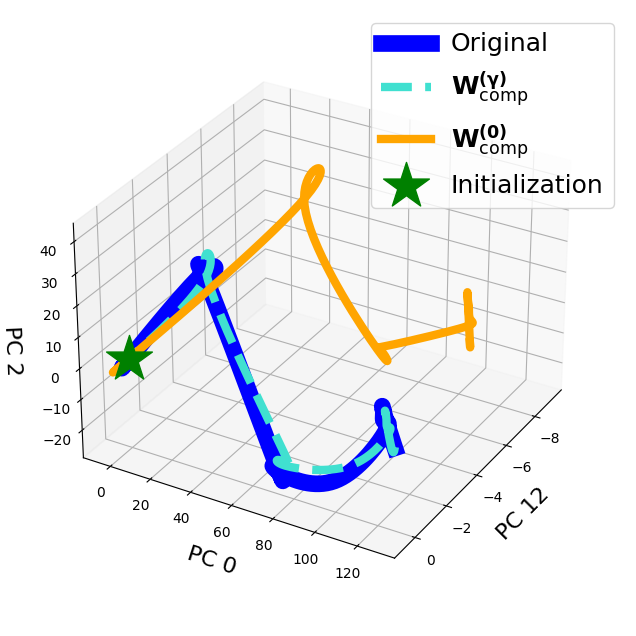

In [15]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection='3d')
ax.plot(red_orig_end_to_end[:, 0], red_orig_end_to_end[:, 1], red_orig_end_to_end[:, 2], linewidth=12, c='blue', linestyle='solid', label='Original')
ax.plot(red_comp_end_to_end[:, 0], red_comp_end_to_end[:, 1], red_comp_end_to_end[:, 2], linewidth=6, c='turquoise', linestyle='dashed', label=r'$\bf{W}^{(\gamma)}_{\mathrm{comp}}$')
ax.plot(red_no_dlr_end_to_end[:, 0], red_no_dlr_end_to_end[:, 1], red_no_dlr_end_to_end[:, 2], linewidth=6, c='orange', linestyle='solid', label=r'$\bf{W}^{(0)}_{\mathrm{comp}}$')
ax.scatter(red_comp_end_to_end[0, 0], red_comp_end_to_end[0, 1], red_comp_end_to_end[0, 2], s=1200, c='green', marker='*', label='Initialization')
elev = 30
azim = 30
roll = 0

ax.legend(fontsize=18)
ax.set_box_aspect(None, zoom=0.9)

ax.set_xlabel('\nPC 12', fontsize=16)
ax.set_ylabel('\nPC 0', fontsize=16)
ax.set_zlabel('\nPC 2', fontsize=16)
ax.view_init(elev, azim, roll)

plt.savefig('figs/equiv_traj_mc_left.png', dpi=300, bbox_inches='tight')

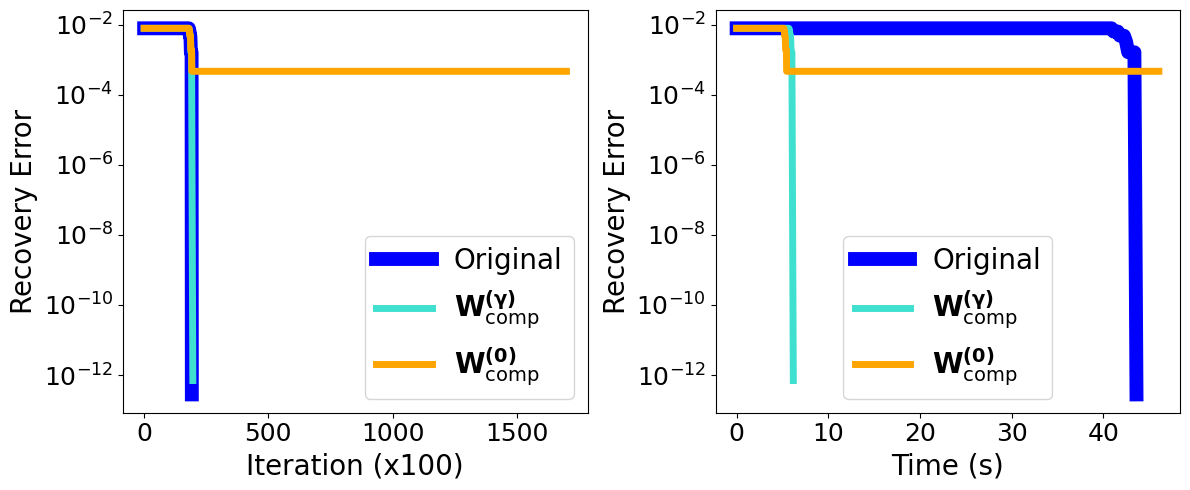

In [16]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121)

ax.semilogy(orig_result['test_loss'], c='blue', linewidth=10, label='Original')
ax.semilogy(comp_result['test_loss'], c='turquoise', linewidth=5, label=r'$\bf{W}^{(\gamma)}_{\mathrm{comp}}$')
ax.semilogy(no_dlr_result['test_loss'], c='orange', linewidth=5, label=r'$\bf{W}^{(0)}_{\mathrm{comp}}$')
ax.set_xlabel('Iteration (x100)', fontsize=20)
ax.set_ylabel('Recovery Error', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)

ax = fig.add_subplot(122)

ax.semilogy(orig_result['time'], orig_result['test_loss'], c='blue', linewidth=10, label='Original')
ax.semilogy(comp_result['time'], comp_result['test_loss'], c='turquoise', linewidth=5, label=r'$\bf{W}^{(\gamma)}_{\mathrm{comp}}$')
ax.semilogy(no_dlr_result['time'], no_dlr_result['test_loss'], c='orange', linewidth=5, label=r'$\bf{W}^{(0)}_{\mathrm{comp}}$')
ax.set_xlabel('Time (s)', fontsize=20)
ax.set_ylabel('Recovery Error', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)

fig.tight_layout()

plt.savefig('figs/equiv_traj_mc_right.png', dpi=300, bbox_inches='tight')

In [17]:
from PIL import Image

image1 = Image.open('figs/equiv_traj_mc_left.png')
image2 = Image.open('figs/equiv_traj_mc_right.png')

(width1, height1) = image1.size
(width2, height2) = image2.size

ratio = height1 / height2

image2 = image2.resize(size=(int(width2 * ratio), int(height2 * ratio)))
(width2, height2) = image2.size

result_width = width1 + width2
result_height = height1

result = Image.new('RGB', (result_width, result_height))
result.paste(im=image1, box=(0, 0))
result.paste(im=image2, box=(width1, 0))

result.save('figs/equiv_traj_mc.png')

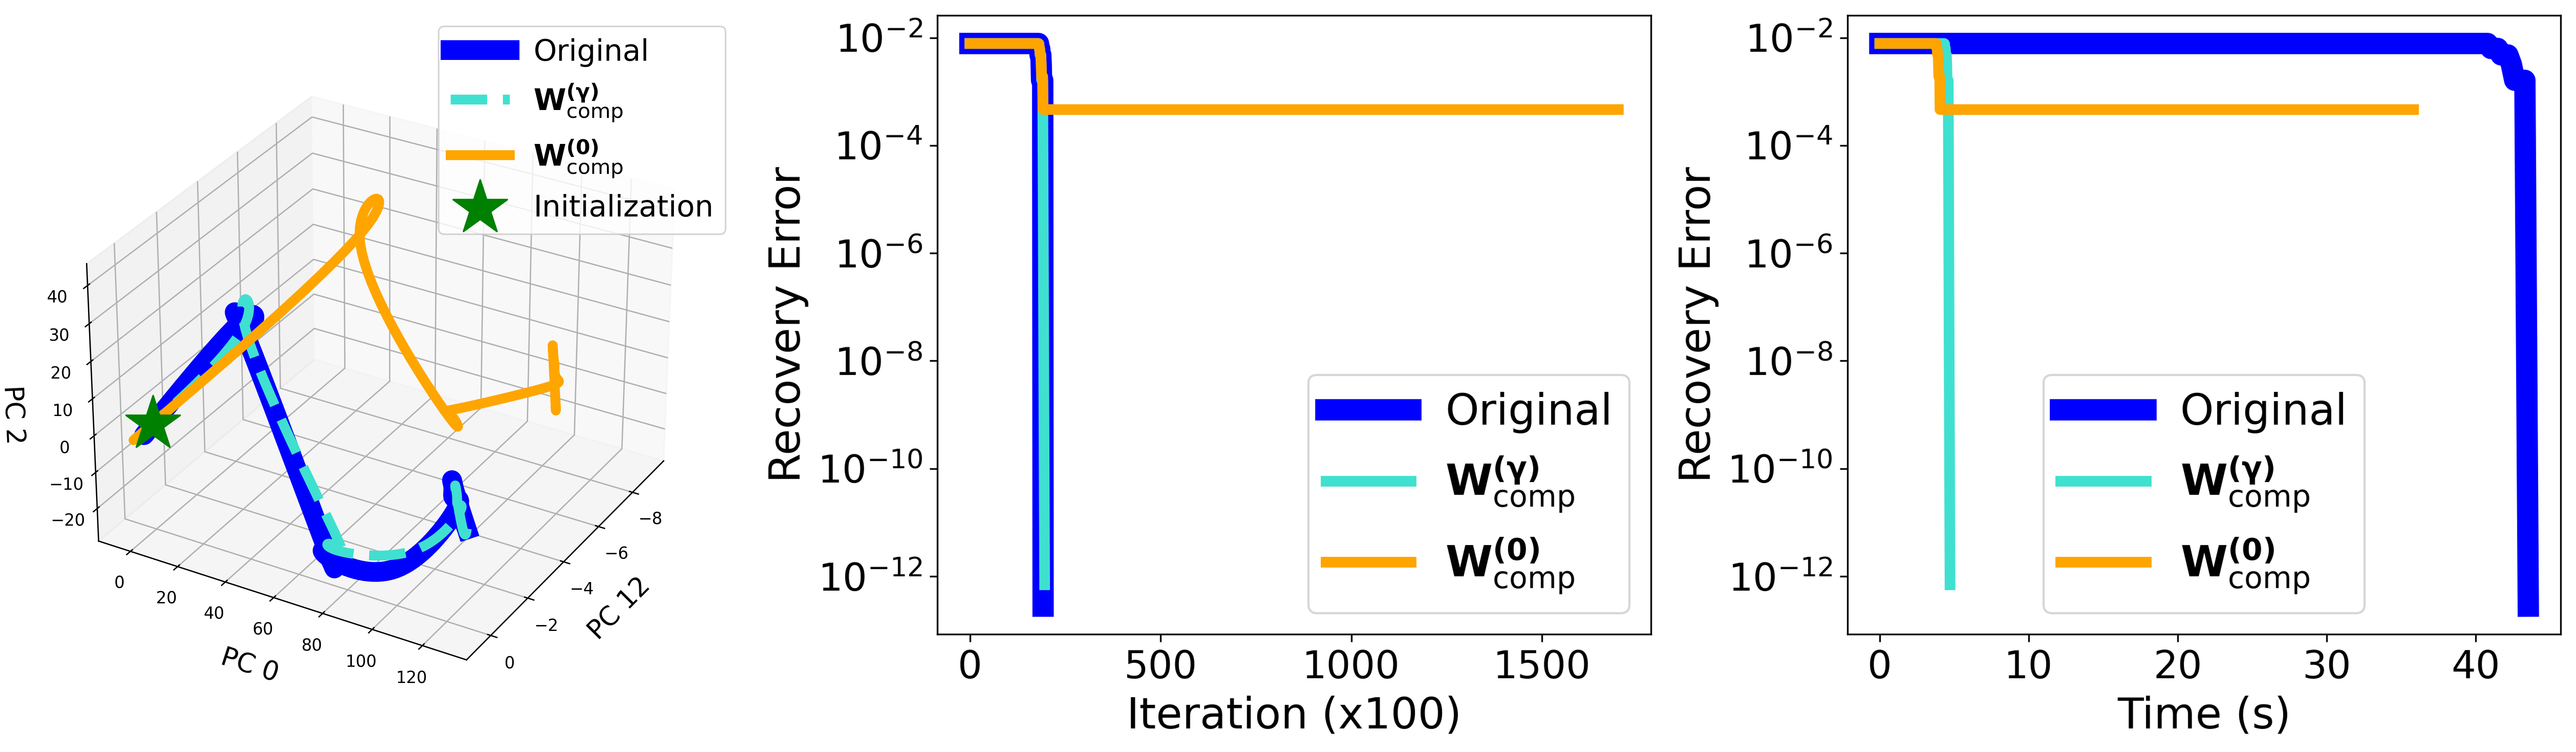

In [13]:
result